In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 150)

import gc
import os

# matplotlib and seaborn for plotting
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120 #resolution
matplotlib.rcParams['figure.figsize'] = (8,6) #figure size

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
color = sns.color_palette()

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.decomposition import PCA

root = '/content/drive/MyDrive/instacart-market-basket-analysis/'

In [ ]:
aisles = pd.read_csv(root + 'aisles.csv')
departments = pd.read_csv(root + 'departments.csv')
orders = pd.read_csv(root + 'orders.csv')
order_products_prior = pd.read_csv(root + 'order_products__prior.csv')
order_products_train = pd.read_csv(root + 'order_products__train.csv')
products = pd.read_csv(root + 'products.csv')

In [ ]:
order_products = order_products_prior.merge(products, on ='product_id', how='left')
order_products = order_products.merge(aisles, on ='aisle_id', how='left')
order_products = order_products.merge(departments, on ='department_id', how='left')
order_products = order_products.merge(orders, on='order_id', how='left')
order_products.shape


(14055507, 15)

In [ ]:
order_products.head()


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120.0,1.0,1.0,Organic Egg Whites,86.0,16.0,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985.0,2.0,1.0,Michigan Organic Kale,83.0,4.0,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327.0,3.0,0.0,Garlic Powder,104.0,13.0,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918.0,4.0,1.0,Coconut Butter,19.0,13.0,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035.0,5.0,0.0,Natural Sweetener,17.0,13.0,baking ingredients,pantry,202279,prior,3,5,9,8.0


In [ ]:
order_products.user_id.nunique()


197894

Segmentation
Since there are thousands of products in the dataset I will rely on aisles, which represent categories of products. Even with aisles features will be too much so I will use Principal Component Analysis to find new dimensions along which clustering will be easier.

In [ ]:
cross_df = pd.crosstab(order_products.user_id, order_products.aisle)
cross_df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,dry pasta,eggs,energy granola bars,energy sports drinks,eye ear care,facial care,feminine care,first aid,food storage,fresh dips tapenades,fresh fruits,fresh herbs,fresh pasta,fresh vegetables,frozen appetizers sides,frozen breads doughs,frozen breakfast,frozen dessert,frozen juice,frozen meals,frozen meat seafood,frozen pizza,frozen produce,frozen vegan vegetarian,fruit vegetable snacks,grains rice dried goods,granola,hair care,honeys syrups nectars,hot cereal pancake mixes,hot dogs bacon sausage,ice cream ice,ice cream toppings,indian foods,instant foods,juice nectars,kitchen supplies,kosher foods,latino foods,laundry,lunch meat,marinades meat preparation,meat counter,milk,mint gum,missing,more household,muscles joints pain relief,nuts seeds dried fruit,oils vinegars,oral hygiene,other,other creams cheeses,packaged cheese,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,2,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,16,0,0,0,0,1,0,0,0,4,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,1,0,0,0,0,2,0,1,0,0,2,0,0,1,0,4,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,23
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,1,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
cross_df.tail()


aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,dry pasta,eggs,energy granola bars,energy sports drinks,eye ear care,facial care,feminine care,first aid,food storage,fresh dips tapenades,fresh fruits,fresh herbs,fresh pasta,fresh vegetables,frozen appetizers sides,frozen breads doughs,frozen breakfast,frozen dessert,frozen juice,frozen meals,frozen meat seafood,frozen pizza,frozen produce,frozen vegan vegetarian,fruit vegetable snacks,grains rice dried goods,granola,hair care,honeys syrups nectars,hot cereal pancake mixes,hot dogs bacon sausage,ice cream ice,ice cream toppings,indian foods,instant foods,juice nectars,kitchen supplies,kosher foods,latino foods,laundry,lunch meat,marinades meat preparation,meat counter,milk,mint gum,missing,more household,muscles joints pain relief,nuts seeds dried fruit,oils vinegars,oral hygiene,other,other creams cheeses,packaged cheese,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
206205,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0,2,0,0,0,0,0,0,0,0,0,3,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
206206,0,0,0,0,0,0,2,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,7,0,0,0,0,0,0,0,8,2,0,0,0,0,0,0,0,1,1,0,6,0,0,2,0,0,4,0,2,0,0,0,0,0,0,0,0,0,21,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,4,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
206207,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,3,1,0,0,0,0,0,0,1,9,0,0,9,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,1,9,0,0,0,0,0,0,0,0,0,7,1,0,0,0,5,0,2,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,4,0,7
206208,0,1,0,0,1,0,1,0,0,0,0,13,0,0,0,0,0,4,1,0,1,1,0,0,3,3,0,0,1,0,1,0,0,6,0,0,0,0,0,3,1,8,8,1,0,0,0,0,0,0,18,7,0,10,0,1,0,0,0,1,0,1,9,0,4,0,0,0,0,0,1,1,0,0,5,0,0,0,0,0,6,2,0,6,0,0,0,0,0,0,0,0,2,2,0,1,2,0,11,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,2,0,0,8,0,0,3,0,1,0,0,1,0,0,0,0,0,5
206209,0,1,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,3,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,3,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,3,1,0,0,3,0,0,0,0,0,2,0,0,1,2,0,0,0,0,4,0,0,1,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
df = cross_df.div(cross_df.sum(axis=1), axis=0)
df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,dry pasta,eggs,energy granola bars,energy sports drinks,eye ear care,facial care,feminine care,first aid,food storage,fresh dips tapenades,fresh fruits,fresh herbs,fresh pasta,fresh vegetables,frozen appetizers sides,frozen breads doughs,frozen breakfast,frozen dessert,frozen juice,frozen meals,frozen meat seafood,frozen pizza,frozen produce,frozen vegan vegetarian,fruit vegetable snacks,grains rice dried goods,granola,hair care,honeys syrups nectars,hot cereal pancake mixes,hot dogs bacon sausage,ice cream ice,ice cream toppings,indian foods,instant foods,juice nectars,kitchen supplies,kosher foods,latino foods,laundry,lunch meat,marinades meat preparation,meat counter,milk,mint gum,missing,more household,muscles joints pain relief,nuts seeds dried fruit,oils vinegars,oral hygiene,other,other creams cheeses,packaged cheese,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.055556,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.222222,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.000000,0.166667,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.055556,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
2,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.044444,0.0,0.0,0.0,0.0,0.022222,0.0,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.177778,0.0,0.0,0.000000,0.0,0.011111,0.0,0.0,0.0,0.044444,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.044444,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.011111,0.0,0.0,0.0,0.000000,0.022222,0.0,0.011111,0.0,0.0,0.022222,0.000000,0.0,0.011111,0.0,0.044444,0.0,0.0,0.0,0.0,0.0,0.0,0.044444,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.011111,0.000000,0.011111,0.000000,0.0,0.0,0.0,0.011111,0.0,0.255556
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.138889,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.222222,0.0,0.0,0.00000

In [ ]:
df.shape


(197894, 134)

PCA and K-Means Clustering
Reducing this dataframe to only 10 dimensions as KMeans does not work properly in higher dimension.

In [ ]:
pca = PCA(n_components=10)
df_pca = pca.fit_transform(df)
df_pca = pd.DataFrame(df_pca)
df_pca.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.005559,0.146044,-0.028326,0.022748,-0.100853,-0.056037,0.105985,0.044603,-0.076470,-0.069206
1,-0.018102,0.121833,-0.063061,-0.161270,0.111634,-0.045311,0.048826,-0.047793,-0.016139,0.010244
2,0.031440,0.143648,0.019867,0.004626,-0.021413,0.138109,0.011224,-0.020914,-0.022789,0.028765
3,-0.002663,0.140487,-0.030963,0.007620,-0.104267,-0.042719,0.071390,-0.008498,0.018915,0.074148
4,0.069242,-0.071881,-0.032367,-0.031794,0.065206,0.087914,-0.016506,0.072013,-0.020682,-0.036905


In [ ]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_pca)
    Sum_of_squared_distances.append(km.inertia_)

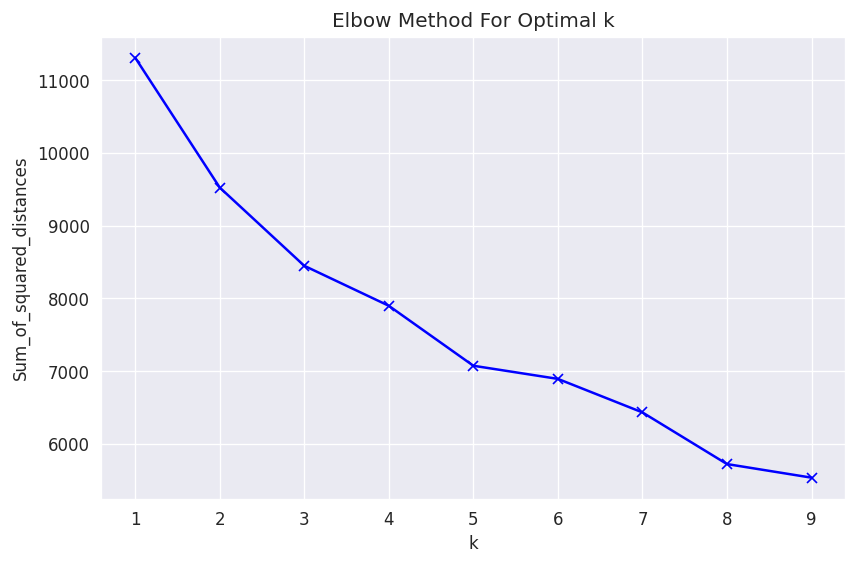

In [ ]:
plt.subplots(figsize = (8, 5))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

From above plot we can choose optimal K as 5



In [ ]:
clusterer = KMeans(n_clusters=5,random_state=42).fit(df_pca)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(df_pca)
print(centers)

[[ 1.06487170e-01  1.58351311e-01  8.66604202e-03  1.92381212e-02
  -3.12087740e-03  1.89961357e-03 -7.31930771e-04  2.50638071e-03
   1.27593748e-03  3.30581706e-04]
 [-3.62289112e-02  2.56565151e-02 -4.51637015e-02 -1.13731068e-01
   9.84028599e-02 -2.32791164e-02  2.15927044e-02  1.10554170e-03
   2.08393291e-03  2.53967144e-04]
 [ 1.09377590e-01 -8.92574885e-02  1.88217132e-02  3.21742518e-03
  -7.07521680e-04 -2.38874984e-03  8.85453115e-04  1.95075397e-03
  -1.02810223e-05  3.47877587e-04]
 [-7.54058549e-02 -9.38754691e-04 -2.51918320e-02  1.47394744e-02
  -1.80888271e-02  4.86595575e-03 -4.10222764e-03 -2.67245939e-03
  -7.94193112e-04 -1.15142770e-04]
 [-2.13994493e-01  3.17012444e-02  3.78002413e-01 -1.98489916e-02
   2.15804265e-02  5.08484085e-03 -3.68605209e-03  1.16296164e-02
   8.43252057e-04 -4.24193136e-03]]


Visualizing clustering among first two principal components


In [ ]:
temp_df = df_pca.iloc[:, 0:2]
temp_df.columns = ["pc1", "pc2"]
temp_df['cluster'] = c_preds
temp_df.head()

<ipython-input-14-dd20da319cba>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['cluster'] = c_preds


,pc1,pc2,cluster
0,-0.005559,0.146044,0
1,-0.018102,0.121833,1
2,0.031440,0.143648,0
3,-0.002663,0.140487,0
4,0.069242,-0.071881,2


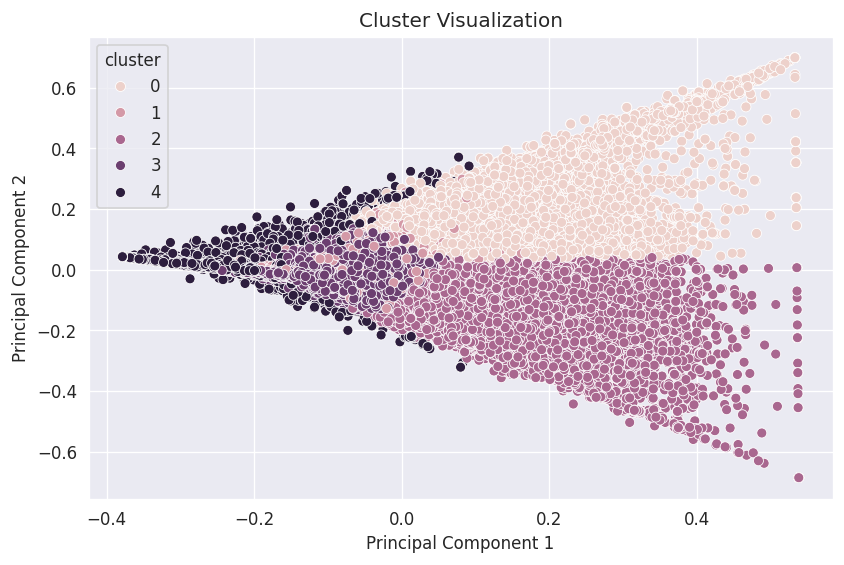

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))
ax = sns.scatterplot(data = temp_df, x = "pc1", y = "pc2", hue = "cluster")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_title("Cluster Visualization")
plt.show();

Top products per cluster


In [ ]:
cross_df['cluster'] = c_preds

cluster1 = cross_df[cross_df.cluster == 0]
cluster2 = cross_df[cross_df.cluster == 1]
cluster3 = cross_df[cross_df.cluster == 2]
cluster4 = cross_df[cross_df.cluster == 3]
cluster5 = cross_df[cross_df.cluster == 4]

In [ ]:
cluster1.shape

(27103, 135)

In [ ]:
cluster1.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]


,0
aisle,
fresh fruits,14.555289
fresh vegetables,4.439730
packaged vegetables fruits,4.114600
yogurt,2.114268
packaged produce,1.909051
milk,1.906099
packaged cheese,1.499465
water seltzer sparkling water,1.236542
soy lactosefree,1.217208


In [ ]:
cluster2.shape


(17500, 135)

In [ ]:
cluster2.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]


,0
aisle,
yogurt,13.211543
fresh fruits,8.190629
fresh vegetables,4.356571
packaged vegetables fruits,3.619943
milk,2.801314
packaged cheese,2.341886
water seltzer sparkling water,1.865029
energy granola bars,1.612800
chips pretzels,1.561543


In [ ]:
cluster3.shape


(54113, 135)

In [ ]:
cluster3.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]


,0
aisle,
fresh vegetables,17.587234
fresh fruits,10.813908
packaged vegetables fruits,5.788868
yogurt,2.767579
packaged cheese,2.362722
milk,1.962634
fresh herbs,1.920943
soy lactosefree,1.741707
frozen produce,1.555948


In [ ]:
cluster4.shape


(94135, 135)

In [ ]:
cluster4.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]


,0
aisle,
fresh fruits,4.793212
fresh vegetables,3.515950
packaged vegetables fruits,2.923036
packaged cheese,2.264089
chips pretzels,2.046200
yogurt,1.997705
milk,1.884825
water seltzer sparkling water,1.874924
refrigerated,1.452435


In [ ]:
cluster5.shape


(5043, 135)

In [ ]:
cluster5.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]


,0
aisle,
water seltzer sparkling water,8.639302
fresh fruits,1.146738
soft drinks,1.030934
yogurt,0.548880
energy granola bars,0.499504
milk,0.453302
chips pretzels,0.432481
packaged vegetables fruits,0.430101
tea,0.426730


Customer Segmentation Results:

Cluster 1 results into 5428 consumers having a very strong preference for water seltzer sparkling water aisle.
Cluster 2 results into 55784 consumers who mostly order fresh vegetables followed by fruits.
Cluster 3 results into 7948 consumers who buy packaged produce and fresh fruits mostly.
Cluster 4 results into 37949 consumers who have a very strong preference for fruits followed by fresh vegetables.
Cluster 5 results into 99100 consumers who orders products from many aisles. Their mean orders are low compared to other clusters which tells us that either they are not frequent users of Instacart or they are new users and do not have many orders yet.